## Collaborative Filtering on Youtube Trending Videos

In [1]:
import re
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# ignoring warnings that pop up during execution
import warnings
warnings.filterwarnings("ignore")

In [2]:
# for libraries not in docker image

# installing libraries
import sys
!{sys.executable} -m pip install missingno
!{sys.executable} -m pip install wordcloud

# importing these libraries
import missingno
from wordcloud import WordCloud, STOPWORDS

In [3]:
# loading the dataset into a dataframe
df = pd.read_csv("dataset/USvideos.csv")

In [4]:
# dimensions of the dataframe
df.shape

(40949, 16)

In [5]:
# column labels of the dataFrame
df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

In [6]:
# summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

In [7]:
# checking for null values
df.isnull().values.any()

True

In [8]:
# count the number of NaNs each column has.
nans = pd.isnull(df).sum()
nans[nans > 0]

description    570
dtype: int64

In [9]:
# grouping columns by datatype
df.dtypes.value_counts()

object    8
int64     5
bool      3
dtype: int64

#### Creating the metric for item based collaborative filtering:

In [10]:
# Calculating the number of views, likes, dislikes and comment count per category
df_num_of_videos_category = df[['category_id','views','likes','dislikes','comment_count']].groupby('category_id').sum()
df_num_of_videos_category.reset_index(inplace=True)

In [11]:
df_num_of_videos_category

,category_id,views,likes,dislikes,comment_count
0,1,7284156721,165997476,6075148,17887060
1,2,520690717,4245656,243010,784447
2,10,40132892190,1416838584,51179008,125296396
3,15,764651989,19370702,527379,2660705
4,17,4404456673,98621211,5133551,11192155
5,19,343557084,4836246,340427,911511
6,20,2141218625,69038284,9184466,14740713
7,22,4917191726,186615999,10187901,24778032
8,23,5117426208,216346746,7230391,22545582
9,24,20604388195,530516491,42987663,73566498


In [12]:
"""
In the given dataset, we found that a single video can trend for multiple days. 
So, we consolidated the views, likes, comment_counts & dislikes for each video.
"""

df_with_ratings = df.groupby(['video_id','title','category_id'],as_index=False).sum()
df_with_ratings = df_with_ratings.drop(['comments_disabled' , 'ratings_disabled', 'video_error_or_removed'], axis=1) 

In [13]:
df_with_ratings.head()

,video_id,title,category_id,views,likes,dislikes,comment_count
0,-0CMnp02rNY,Mindy Kaling's Daughter Had the Perfect Reacti...,24,4134702,52197,1646,2215
1,-0NYY8cqdiQ,Megan Mullally Didn't Notice the Interesting P...,24,563746,4429,54,94
2,-1Hm41N0dUs,Cast of Avengers: Infinity War Draws Their Cha...,23,5507675,112165,1503,4386
3,-1yT-K3c6YI,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,22,777243,27305,713,2928
4,-2RVw2_QyxQ,2017 Champions Showdown: Day 3,27,208304,1351,76,62


In [14]:
# dropping nan values
df_with_ratings = df_with_ratings.dropna()
df_with_ratings.reset_index(inplace=True)
df_with_ratings.head()

,index,video_id,title,category_id,views,likes,dislikes,comment_count
0,0,-0CMnp02rNY,Mindy Kaling's Daughter Had the Perfect Reacti...,24,4134702,52197,1646,2215
1,1,-0NYY8cqdiQ,Megan Mullally Didn't Notice the Interesting P...,24,563746,4429,54,94
2,2,-1Hm41N0dUs,Cast of Avengers: Infinity War Draws Their Cha...,23,5507675,112165,1503,4386
3,3,-1yT-K3c6YI,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,22,777243,27305,713,2928
4,4,-2RVw2_QyxQ,2017 Champions Showdown: Day 3,27,208304,1351,76,62


In [15]:
# dropping duplicates
df_with_ratings = df_with_ratings.drop_duplicates(subset=['video_id'], keep = 'last')
df_with_ratings.reset_index(inplace=True)

In [16]:
# dropping duplicate index (level_0)
df_with_ratings = df_with_ratings.drop(['level_0', 'index'], axis=1)

In [17]:
df_with_ratings

,video_id,title,category_id,views,likes,dislikes,comment_count
0,-0CMnp02rNY,Mindy Kaling's Daughter Had the Perfect Reacti...,24,4134702,52197,1646,2215
1,-0NYY8cqdiQ,Megan Mullally Didn't Notice the Interesting P...,24,563746,4429,54,94
2,-1Hm41N0dUs,Cast of Avengers: Infinity War Draws Their Cha...,23,5507675,112165,1503,4386
3,-1yT-K3c6YI,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,22,777243,27305,713,2928
4,-2RVw2_QyxQ,2017 Champions Showdown: Day 3,27,208304,1351,76,62
...,...,...,...,...,...,...,...
6346,zwEn-ambXLw,This Is Me - Cover by Shoshana Bean Featuring ...,10,2272376,81926,1350,3392
6347,zxUwbflE1SY,100 People Hold Their Breath for as Long as Th...,24,1058951,27664,717,6223
6348,zxwfDlhJIpw,kanye west / charlamagne interview,22,177659300,3637418,420856,1063860
6349,zy0b9e40tK8,Dark | Official Trailer [HD] | Netflix,24,378750,5642,146,675


#### Generating the ratings per video:

* The views, likes, dislikes and comment counts were grouped and aggregated by the category-id leaving us with 16 different values for the 4 attributes as we have 16 categories in total.
* The views, likes, dislikes and comment counts of each video are normalized over its particular category using the values calculated in step ‘a’.
* This leaves us with a value between 0 and 1 for each video’s likes, dislikes, views and comment counts.
* We then assign some fixed weight to each of the ratios of views, likes, dislikes and comment counts. After multiplying these weights, we sum up these four ratios and again have a value between 0 to 1.
* Using min-max normalization technique, we bring these ratings in a range of 0 to 10. 
* Finally, we append a rating column to our original dataset with these calculated rating values.

In [18]:
rating_list = []
view_weight = 0.5
like_weight = 0.3
disike_weight = 0.1
comment_weight = 0.1
for index_og,row_og in df_with_ratings.iterrows():
    for index_new, row_new in df_num_of_videos_category.iterrows():
        if row_og['category_id'] == row_new['category_id']:
            ratio_views = float(row_og['views']/row_new['views'])
            ratio_likes = float(row_og['likes']/row_new['likes'])
            ratio_dislikes = float(row_og['dislikes']/row_new['dislikes'])
            ratio_comments = float(row_og['comment_count']/row_new['comment_count'])
            total_sum = (ratio_views * view_weight) + (ratio_likes * like_weight) + (ratio_dislikes * disike_weight) + (ratio_comments * comment_weight)
            rating_list.append(total_sum)

In [19]:
# Appending rating column to dataframe
df_with_ratings['rating'] = rating_list

In [20]:
df_with_ratings.head()

,video_id,title,category_id,views,likes,dislikes,comment_count,rating
0,-0CMnp02rNY,Mindy Kaling's Daughter Had the Perfect Reacti...,24,4134702,52197,1646,2215,0.000137
1,-0NYY8cqdiQ,Megan Mullally Didn't Notice the Interesting P...,24,563746,4429,54,94,0.000016
2,-1Hm41N0dUs,Cast of Avengers: Infinity War Draws Their Cha...,23,5507675,112165,1503,4386,0.000734
3,-1yT-K3c6YI,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,22,777243,27305,713,2928,0.000142
4,-2RVw2_QyxQ,2017 Champions Showdown: Day 3,27,208304,1351,76,62,0.000103


In [21]:
min_rating = df_with_ratings['rating'].min()
print("Min rating before Normalization: ", min_rating)

Min rating before Normalization:  4.5331612154915544e-08


In [22]:
max_rating = df_with_ratings['rating'].max()
print("Max rating before Normalization: ", max_rating)

Max rating before Normalization:  0.9512967920524744


#### Min-Max Normalization of the ratings to get them in range 0 to 10:

In [23]:
for index, row in df_with_ratings.iterrows():
    normalized = ((row['rating'] - min_rating) / (max_rating - min_rating)) * 10
    df_with_ratings.at[index,'rating'] = normalized

In [24]:
df_with_ratings.head()

,video_id,title,category_id,views,likes,dislikes,comment_count,rating
0,-0CMnp02rNY,Mindy Kaling's Daughter Had the Perfect Reacti...,24,4134702,52197,1646,2215,0.001436
1,-0NYY8cqdiQ,Megan Mullally Didn't Notice the Interesting P...,24,563746,4429,54,94,0.000172
2,-1Hm41N0dUs,Cast of Avengers: Infinity War Draws Their Cha...,23,5507675,112165,1503,4386,0.007714
3,-1yT-K3c6YI,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,22,777243,27305,713,2928,0.001490
4,-2RVw2_QyxQ,2017 Champions Showdown: Day 3,27,208304,1351,76,62,0.001084


In [25]:
max_rating = df_with_ratings['rating'].max()
print("Max rating after Normalization: ", max_rating)

Max rating after Normalization:  10.0


In [26]:
min_rating = df_with_ratings['rating'].min()
print("Min rating after Normalization: ", min_rating)

Min rating after Normalization:  0.0


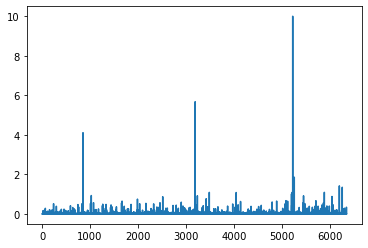

In [27]:
plt.plot(df_with_ratings['rating'])

In [28]:
# Video with highest rating!

df_with_ratings[(df_with_ratings.rating == 10)]

,video_id,title,category_id,views,likes,dislikes,comment_count,rating
5227,oWjxSkJpxFU,Suicide: Be Here Tomorrow.,29,157627870,14271026,3239399,4710338,10.0


In [29]:
# Video with lowest ratings :(

df_with_ratings[(df_with_ratings.rating == 0)]

,video_id,title,category_id,views,likes,dislikes,comment_count,rating
2589,OmM425PFd3Y,How Noah Galvin Makes Evan Hansen His Own,24,1402,20,0,0,0.0


In [30]:
video_id_length = df_with_ratings['video_id'].size

#### Generating Random users and assigning them videos they have watched randomly for recommendation purposes:

In [31]:
user_name_df = pd.read_csv('dataset/username.txt', header=None)
user_name_df.columns = ['username']

In [32]:
user_name_df

,username
0,Loriana
1,Solvi
2,Marita
3,Oberyn
4,Paarth
...,...
1195,Destiny Mckay
1196,Rex Herring
1197,Kyler Spears
1198,Aleah Hopkins


In [33]:
"""
Preferences are designated to each user in the following way: We have a total of 16 categories. 
The first 25% of all users have preference towards the first four categories (category_id: 1, 2, 10, 15), the next 25% users have a preference to next four categories and so on.

Multiple videos are randomly assigned to each user depending on their preference. 
Most of the videos watched by the user are assigned to them from their preferred category 
but there are few videos assigned from other categories as well to model real world scenario.
"""
list_videos = []
list_ratings = []
list_categories = []
categories_1 = [1, 2, 10, 15]
categories_2 = [17, 19, 20, 22]
categories_3 = [23, 24, 25, 26]
categories_4 = [27, 28, 29, 43]

rand_size = video_id_length
for i in range(user_name_df['username'].size):
    user_list = []
    category_list = []
    user_ratings = []
    for j in range(np.random.randint(300,500)):
        if i <= 299:
            index = np.random.randint(rand_size)
            if df_with_ratings['category_id'][index] in categories_1:
                user_list.append(df_with_ratings['video_id'][index])
                category_list.append(df_with_ratings['category_id'][index])
        elif i > 299 and i <= 599:
            index = np.random.randint(rand_size)
            if df_with_ratings['category_id'][index] in categories_2:
                user_list.append(df_with_ratings['video_id'][index])
                category_list.append(df_with_ratings['category_id'][index])
        elif i > 599 and i <= 999:
            index = np.random.randint(rand_size)
            if df_with_ratings['category_id'][j] in categories_3:
                user_list.append(df_with_ratings['video_id'][index])
                category_list.append(df_with_ratings['category_id'][index])
        elif i > 999 and i <= 1199:
            index = np.random.randint(rand_size)
            if df_with_ratings['category_id'][index] in categories_4:
                user_list.append(df_with_ratings['video_id'][index])
                category_list.append(df_with_ratings['category_id'][index])
    list_videos.append(user_list)
    list_ratings.append(user_ratings)
    list_categories.append(category_list)

In [34]:
# Appending watched videos to users
user_name_df['watched'] = list_videos
user_name_df

,username,watched
0,Loriana,"[-xAMnJgc3oA, VqcHUdHQ1u8, y4EbUvQ4a5s, l3vbvF..."
1,Solvi,"[bVU-MmJZFFA, D18e8aU-UWs, 07JQ4WZJIbg, enqFul..."
2,Marita,"[IXNrHusLXoM, NsJkUfrqLzY, Fjm81OPZbpU, e4FApt..."
3,Oberyn,"[caN18WcW5XU, i_nLsG_asQg, nUmO7rBMdoU, Spdgah..."
4,Paarth,"[PzcaR1N0pTI, 76XBys_HXq4, KWn4JmiM2pM, jH2t4T..."
...,...,...
1195,Destiny Mckay,"[TaldfjkrHy4, BGk6_KEFtLE, xGCnZ-9dPc0, fbL1Zo..."
1196,Rex Herring,"[phiDj5nlF5c, -HrakxB4Klo, kJzSzGbfc0k, m7Ege1..."
1197,Kyler Spears,"[O4_JNAFClFk, sW5HaEsnuMI, D3BJ5bt5VbA, Zzi4EQ..."
1198,Aleah Hopkins,"[AJUiQU8-w8E, h8ycmroFQSs, vAGtarDX544, hv3jeG..."


In [35]:
# transforming elements watched to a row, replicating index values
user_name_df = user_name_df.explode('watched')

In [36]:
user_name_df['user_id'] = user_name_df.index

In [37]:
user_name_df

,username,watched,user_id
0,Loriana,-xAMnJgc3oA,0
0,Loriana,VqcHUdHQ1u8,0
0,Loriana,y4EbUvQ4a5s,0
0,Loriana,l3vbvF8bQfI,0
0,Loriana,_BcYBFC6zfY,0
...,...,...,...
1199,Shiloh Logan,iDbdXTMnOmE,1199
1199,Shiloh Logan,voozHXadYYE,1199
1199,Shiloh Logan,D5bEwcJ8eCI,1199
1199,Shiloh Logan,RkU4WWEUj-Y,1199


In [38]:
df_ratings_small = df_with_ratings.iloc[:, 0:4]

In [39]:
df_ratings_small.head()

,video_id,title,category_id,views
0,-0CMnp02rNY,Mindy Kaling's Daughter Had the Perfect Reacti...,24,4134702
1,-0NYY8cqdiQ,Megan Mullally Didn't Notice the Interesting P...,24,563746
2,-1Hm41N0dUs,Cast of Avengers: Infinity War Draws Their Cha...,23,5507675
3,-1yT-K3c6YI,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,22,777243
4,-2RVw2_QyxQ,2017 Champions Showdown: Day 3,27,208304


#### Exporting Data to CSV file:

In [40]:
# Storing users and their watched videos
user_name_df.to_csv('user_watched_'+str(user_name_df['username'].size)+'.csv', index=False)

In [41]:
user_watched_video_category_df = user_name_df.merge(df_ratings_small, left_on='watched', right_on='video_id')

In [42]:
user_watched_video_category_df = user_watched_video_category_df.drop(['video_id'], axis=1)

In [43]:
user_watched_video_category_df = user_watched_video_category_df.sort_values(by = 'user_id')

In [44]:
user_name_df = user_name_df.dropna()

In [45]:
user_watched_video_category_df.to_csv('user_watched_video_category_' +str(user_watched_video_category_df['username'].size)+  '.csv', index=False)

In [46]:
# Finding the quartiles of ratings
df_with_ratings.rating.quantile([0.25,0.5,0.75])

0.25    0.000594
0.50    0.003200
0.75    0.014491
Name: rating, dtype: float64

#### Computing user ratings for watched videos:

In [47]:
rating_array = np.array(df_with_ratings['rating'])
# rating_array = np.round(rating_array, 6)
rating_array

array([1.43642596e-03, 1.72321024e-04, 7.71431515e-03, ...,
       3.39925593e-01, 1.42892499e-04, 1.12306293e-04])

In [48]:
video_dict = {}
rating_index = 0
for index_og,row_og in df_with_ratings.iterrows():
    video_dict[row_og['video_id']] = tuple((row_og['category_id'], index_og, row_og['rating']))
    rating_index += 1
# video_dict

In [49]:
watched_list = list(user_name_df['watched'])

In [50]:
watched_list[0]

'-xAMnJgc3oA'

In [51]:
new_rating_array = np.zeros(user_name_df['username'].size)

* Using the above calculated ratings, ratings of individual users are generated randomly.
* For instance, if the rating from original dataset, let’s say, Ry:
    * If Ry is under the 1st quartile, a random rating between 0 to 3.0 can be assigned by the user to that video. 
    * If Ry lies in the first quartile to median range, a random rating between 1.0 to 4.0 can be assigned. 
    * If Ry lies in the median to third quartile range, a random rating between 3.0 to 4.0 can be assigned.  
    * If Ry is above 3rd quartile, a random rating between 3.5 to 5.0 can be assigned by the user to that video. 
* Finally, a rating column is appended to the dummy dataset which contains rating by each user between 0 to 5 for every video the user has watched.

In [52]:
first_quartile = np.round(float(df_with_ratings.rating.quantile([0.25])),8)
median = np.round(float(df_with_ratings.rating.quantile([0.5])), 8)
third_quartile = np.round(float(df_with_ratings.rating.quantile([0.75])), 8)
watched_index = 0

for rating_index in range(len(new_rating_array)):
    if video_dict[watched_list[watched_index]][2] <= first_quartile:
        new_rating_array[rating_index] = np.random.randint(0.0,3.0)
    elif video_dict[watched_list[watched_index]][2] > first_quartile and video_dict[watched_list[watched_index]][2] <= median:
        new_rating_array[rating_index] = np.random.randint(1.0,4.0)
    elif video_dict[watched_list[watched_index]][2] > median and video_dict[watched_list[watched_index]][2] <= third_quartile:
        new_rating_array[rating_index] = np.random.randint(3.0,4.0)
    elif video_dict[watched_list[watched_index]][2] > third_quartile:
        new_rating_array[rating_index] = np.random.randint(3.5,5.0)
    watched_index += 1

In [53]:
user_name_df['rating'] = list(new_rating_array)

In [54]:
user_name_df

,username,watched,user_id,rating
0,Loriana,-xAMnJgc3oA,0,1.0
0,Loriana,VqcHUdHQ1u8,0,3.0
0,Loriana,y4EbUvQ4a5s,0,2.0
0,Loriana,l3vbvF8bQfI,0,3.0
0,Loriana,_BcYBFC6zfY,0,4.0
...,...,...,...,...
1199,Shiloh Logan,iDbdXTMnOmE,1199,4.0
1199,Shiloh Logan,voozHXadYYE,1199,3.0
1199,Shiloh Logan,D5bEwcJ8eCI,1199,3.0
1199,Shiloh Logan,RkU4WWEUj-Y,1199,1.0


In [55]:
user_name_df.to_csv('user_ratings_' +str(user_name_df['username'].size)+ '.csv',index=False)

In [56]:
user_name_df

,username,watched,user_id,rating
0,Loriana,-xAMnJgc3oA,0,1.0
0,Loriana,VqcHUdHQ1u8,0,3.0
0,Loriana,y4EbUvQ4a5s,0,2.0
0,Loriana,l3vbvF8bQfI,0,3.0
0,Loriana,_BcYBFC6zfY,0,4.0
...,...,...,...,...
1199,Shiloh Logan,iDbdXTMnOmE,1199,4.0
1199,Shiloh Logan,voozHXadYYE,1199,3.0
1199,Shiloh Logan,D5bEwcJ8eCI,1199,3.0
1199,Shiloh Logan,RkU4WWEUj-Y,1199,1.0


In [57]:
user_name_df['rating'] = user_name_df.rating.astype(float)
ratings = pd.DataFrame(user_name_df.groupby('watched')['rating'].max())

In [58]:
ratings['number_of_ratings'] = pd.DataFrame(user_name_df.groupby('watched')['rating'].count())
ratings.head()

,rating,number_of_ratings
watched,,
-0CMnp02rNY,3.0,13
-0NYY8cqdiQ,2.0,7
-1Hm41N0dUs,3.0,10
-1yT-K3c6YI,3.0,44
-2RVw2_QyxQ,3.0,28


#### Joint plot of rating vs num of rating:

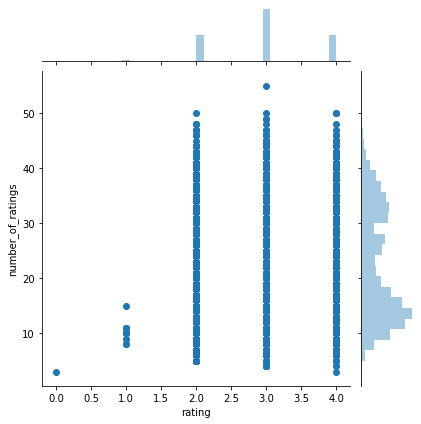

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.jointplot(x='rating', y='number_of_ratings', data=ratings)

In [60]:
df_with_ratings_and_userid = user_name_df

In [61]:
df_with_ratings[df_with_ratings['title'] == 'WE WANT TO TALK ABOUT OUR MARRIAGE']

,video_id,title,category_id,views,likes,dislikes,comment_count,rating
376,2kyS6SvSYSE,WE WANT TO TALK ABOUT OUR MARRIAGE,22,15220962,615779,49012,149396,0.03807


In [62]:
df_with_ratings['rating'][df_with_ratings['video_id'] == '-0CMnp02rNY']

0    0.001436
Name: rating, dtype: float64

In [63]:
df_temp_avg_rating = df_with_ratings.groupby('video_id', as_index=False)['rating'].max()
df_temp_avg_rating['rating'][df_temp_avg_rating['video_id'] == 'tx-9LkVIdz0']

5819    0.007224
Name: rating, dtype: float64

In [64]:
df_temp_avg_rating

,video_id,rating
0,-0CMnp02rNY,0.001436
1,-0NYY8cqdiQ,0.000172
2,-1Hm41N0dUs,0.007714
3,-1yT-K3c6YI,0.001490
4,-2RVw2_QyxQ,0.001084
...,...,...
6346,zwEn-ambXLw,0.000536
6347,zxUwbflE1SY,0.000541
6348,zxwfDlhJIpw,0.339926
6349,zy0b9e40tK8,0.000143


In [65]:
user_name_df_new = user_name_df.merge(df_with_ratings[list(['video_id','title'])],left_on='watched',right_on='video_id')

In [66]:
user_name_df_new = user_name_df_new.drop(['video_id'],axis=1)

In [67]:
user_name_df_new

,username,watched,user_id,rating,title
0,Loriana,-xAMnJgc3oA,0,1.0,Janelle Monáe – I Like That [Official Audio]
1,Celina,-xAMnJgc3oA,18,3.0,Janelle Monáe – I Like That [Official Audio]
2,Hawkin,-xAMnJgc3oA,21,3.0,Janelle Monáe – I Like That [Official Audio]
3,Dalin,-xAMnJgc3oA,30,3.0,Janelle Monáe – I Like That [Official Audio]
4,Erim,-xAMnJgc3oA,57,3.0,Janelle Monáe – I Like That [Official Audio]
...,...,...,...,...,...
141159,Leticia Glenn,WArjc_PF2b4,887,2.0,"Stock market plunges, but it's not time to panic"
141160,Emmett Vazquez,WArjc_PF2b4,891,0.0,"Stock market plunges, but it's not time to panic"
141161,Aaden Stephens,WArjc_PF2b4,942,1.0,"Stock market plunges, but it's not time to panic"
141162,Winston Boyle,WArjc_PF2b4,964,1.0,"Stock market plunges, but it's not time to panic"


#### Creating User - Item interaction matrix

In [68]:
#creating the user-item interaction matrix
video_matrix_UII = user_name_df_new.pivot_table(index='user_id', columns='title', values='rating')
video_matrix_UII

title,#184 Making a PCB using EasyEDA. // Review,"#23 Feed The Homeless | One List, One Life",#57: AM and SSB explained,"#AboveTheNoise feat. Serena Williams, Neymar Jr., Cara Delevingne, Michael K. Williams, and Kris Wu",#DisneyParksLIVE: Fantasy In The Sky New Years Eve Fireworks | Disney World,#DisneyParksLIVE: Super Bowl Celebration | Walt Disney World,#EDGYTOKEI,#GuacWorld :60 | 2018 Big Game Commercial | Avocados From Mexico,#HurtBae 2: One Year Later - Kourtney and Leonard Meet Again | Iris,"#MeToo Backlash | January 17, 2018 Act 1 | Full Frontal on TBS",...,巨大なうさぎを癒すねこ。-Maru heals the huge rabbit.-,긴박했던 상황...'판문점 귀순' CCTV·TOD 영상 공개 / YTN,말차 까눌레 만들기 | 한세,생후 60일 된 새끼가 사라졌다!!?,한국 치맥 왕중왕전: 외국인 입맛에 제일 잘 맞는 한국 치킨은?!,힐링쿠킹♥ 빙글빙글 회오리젤리 만들기! - Ari Kitchen(아리키친),"🍒 april favs 🍒 (music, clothes, life)",🍫달콤 쌉사름~ 리얼 초콜릿 우유 만들기 Real Chocolate Milk | 한세,🎃 How to make Pumpkin Pie Mistakes,"😱 $1,145 iPhone Case!!"
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
#Most rated movies --- this list
merged_ratings = ratings.merge(df_ratings_small, left_on='watched', right_on='video_id')
merged_ratings.sort_values('number_of_ratings', ascending=False).head(25)

,rating,number_of_ratings,video_id,title,category_id,views
386,3.0,55,2qzrjzN5ns0,Stephen A. hyped over Kevin Durant's Game 3: H...,17,1863078
4891,3.0,50,lJmDmfQOWVw,BECOMING ADAM RIPPON // Grace Helbig,22,866303
4641,4.0,50,ill2cgCyTUc,The Historic Disappearance of Louis Le Prince,22,12065615
5877,4.0,50,ufynqs_COF4,J. Cole - Kevin's Heart,10,226451213
2062,2.0,50,JdrdNQfZoqs,Skelly the Skeleton Robot wishing you a Merry ...,22,4767
2940,3.0,49,STI2fI7sKMo,WE GOOGLED OURSELVES | Shawn and Andrew,22,1050116
3297,3.0,49,WI06POju7UQ,"Jimmy Kimmel monologue - Jan 11, 2018 | Trump ...",22,1155214
457,2.0,48,3Xb3eOH4PMA,When dad hijacks elf on a shelf 😉🎄,22,85366
3353,3.0,48,WpTjFhA09kQ,“Why can’t i stop dreaming about waffles” 🤣😂🤣,22,1888321
5553,4.0,48,rdeQT7KkqM8,"$1 Bagel vs. $1,000 Bagel",22,14733149


### Some recommendation results to analyze:

In [71]:
def suggest_videos_to_watch_like(video_title):
    user_rating = video_matrix_UII[video_title]
    similarity_to_video = video_matrix_UII.corrwith(user_rating)
    result_df = pd.DataFrame(similarity_to_video.dropna())
    result_df.columns = ['corr']
    result_df.reset_index(inplace=True)
    res_merged = result_df.merge(df_ratings_small, left_on='title', right_on='title')
    return res_merged.sort_values(by=['corr'],ascending=False).head(20)

In [73]:
suggest_videos_to_watch_like("Half Magic - Official Trailer")

,title,corr,video_id,category_id,views
26,"Barry & Iris Married, Oliver & Felicity Marrie...",1.0,fy5hua8oEVQ,1,524217
23,Anti Tank Crossbow!,1.0,Ft-cmkjgOlk,1,60624
187,Portugal. The Man - Keep On (Official Video),1.0,K6Zu3qKhON4,10,1370156
228,TWICE Merry & Happy M/V,1.0,zi_6oaQyckM,10,71146335
5,2018 Billboard Music Awards Live Nominations A...,1.0,YzTWzK2Ke5Q,10,853052
43,Cat Mind Control,1.0,pspGtXW0QYo,15,5969959
240,The Script - Arms Open (Benny Benassi x MazZz ...,1.0,KUSc7aScV9w,10,139427
260,Westworld Season 2 | Official Super Bowl LII A...,1.0,qUmfriZoMw0,1,88678208
104,Here And Now Official Trailer (2018) | HBO,1.0,pWqRw4NfFDA,1,283160
110,How to make the KELP SHAKE from Spongebob Squa...,1.0,RBbkCEHBw_I,26,15698206


In [74]:
suggest_videos_to_watch_like("The Weirdest Mystery Tech Yet...")

,title,corr,video_id,category_id,views
215,What If We Destroyed the Moon?,1.0,gkvhlo4a5iQ,27,3770984
192,This Week I Learned to Saber a Champagne Bottle,1.0,UXm1xHECZu0,24,2035163
45,Ending Daily Vlogs. Not Clickbait,1.0,ck2ClsAoN8w,22,35159998
160,Spiderman dancing Take on me by A-Ha | DJ IVAN...,1.0,pfX353Wc0GA,24,548778
82,I AUDITIONED FOR THE VOICE!,1.0,1sqyuXCwcBA,23,9200677
170,Strong Santa Ana Wind and Extreme Fire Danger ...,1.0,w4n1XcBdwFk,28,19932
130,Nichola Joss's Top 3 Facial Massage Techniques...,1.0,piyds9slayg,26,87785
10,A Metal Waterfall,1.0,MLTwWIeiA24,24,2337251
174,Tamar Braxton Clears Up Rumors About Her Marri...,1.0,d3PMBPw74cc,24,3390134
197,Tori Kelly - Help Us To Love (Audio) ft. The H...,1.0,d2TrEsA3nzg,10,302998


In [76]:
suggest_videos_to_watch_like("Jack White - Connected By Love")

,title,corr,video_id,category_id,views
579,"Zedd, Maren Morris, Grey - The Middle (Lyric V...",1.0,Lj6Y6JCu-l4,10,8256954
225,Honest Trailers - It (2017),1.0,4ubwGb-vLA0,1,16960481
582,[FULL STREAM] Open doors training session,1.0,f7kPSYWU1JA,24,462939
317,Lucas the Spider - Giant Spider,1.0,v7H_Or9Nr5I,1,154043213
216,Haul Video #2 | Tacos!,1.0,DFZmEaNqdNc,1,192332
37,All the best reactions to James Harden's nasty...,1.0,6VJYkH1WfKc,17,390622
331,Mariah Carey - Lil Snowman,1.0,Nl6YEW1s7x8,10,2330043
44,Ansel Elgort - Supernova,1.0,Q-oM2BQ8Jow,10,7590243
404,Paterno (2018) Official Trailer ft. Al Pacino ...,1.0,scI7dYdlzuY,1,898598
164,Eminem - Untouchable (Audio),1.0,56KYMMGudcU,10,46728397


In [77]:
suggest_videos_to_watch_like("My asthmatic kitty cat getting his meds")

,title,corr,video_id,category_id,views
162,Jason Momoa & Lisa Bonet: Love at First Sight,1.0,cOc3tsFWoRs,24,1497519
271,Silence Breakers: Women Affected By Sexual Mis...,1.0,JlcJaCS4BPM,25,24397
97,EVACUATING A FLOOD IN THE PHILIPPINES (Tropica...,1.0,4zkWYYFvV6M,22,1673771
18,2018 Winter Olympics Recap Day 3 I Part 1 (Jam...,1.0,uzK1OmxS4CE,17,266874
123,Granulated Sugar From Honey,1.0,Jidk0O6uu-0,22,342379
224,Nihon Nights: Discover Japan's custom supercar...,1.0,uFUHjJQIC_4,17,363340
314,The Outsider | Official Trailer [HD] | Netflix,1.0,QNNcl2mEHzQ,24,3659326
143,IS THIS THE CAMERA OF THE FUTURE?,1.0,nMbUA7dghlk,22,11035376
197,MY THOUGHTS ABOUT MAKING THE FORBES LIST,1.0,M3W0ELaAOIg,22,896582
96,ETRADE Super Bowl Commercial 2018 This Is Get...,1.0,3ILxrRlf3KY,10,6377720


In [78]:
suggest_videos_to_watch_like("[OFFICIAL VIDEO] Attention - Pentatonix")

,title,corr,video_id,category_id,views
345,Screen Junkies 2017 Oscar Nominations: Our Aca...,1.0,upt1wHntDws,1,1048521
11,2CELLOS - Cinema Paradiso [OFFICIAL VIDEO],1.0,ozkqm2ifMw8,10,432186
75,Christopher Robin Official Trailer,1.0,0URpDxIjZrQ,1,89055881
63,Carla Makes Granola Cluster Cookies | From the...,1.0,vgX5M1eVhyw,26,164125
443,X Ambassadors - JOYFUL,1.0,AuWwlxym68g,10,1292530
399,Thirty Seconds To Mars - Dangerous Night (Audio),1.0,yN7N0P2TxHQ,10,4994625
416,U2: Live in der Berliner U-Bahnlinie U2: „Get ...,1.0,VKY5Ws1Ys1w,10,141352
450,[OFFICIAL VIDEO] Attention - Pentatonix,1.0,m1-rpd3S-48,10,72222190
76,Claire Danes And The 'Homeland' Cast Have 'Spy...,1.0,d6mBbyb-vIA,24,433711
81,Conan Plays Horse With Magic Johnson - CONAN ...,1.0,JBTNG-8w5_g,23,1979985


In [80]:
suggest_videos_to_watch_like("Ralph Breaks the Internet: Wreck-It Ralph 2 Official Trailer")

,title,corr,video_id,category_id,views
298,Why did young voters pick a 92-year-old? - BBC...,1.0,t8aPNtKYABk,25,3238444
17,ANIMALS BITE ME...a lot.,1.0,NZ0ImXT1FZk,15,9556980
158,KITTEN and CAT,1.0,SJsvPv5Q_oY,15,1859327
109,Head Over Heels (A Valentines Special) - Simon...,1.0,rplCCSqWXIY,15,2660130
265,The Ultimate Red Lip Look | Nicole Guerriero,1.0,EYkEshCOhEU,22,602739
165,Kris Jenner - Introducing My Kris Jenner Colle...,1.0,A2dIL4sf4TQ,22,12063290
168,LA vs NY Kids – Who's Smarter?,1.0,7s71D2kQrFE,24,4236925
269,Three Days Grace - The Mountain (Official Video),1.0,XblV5A1PlDo,10,5527420
275,Top breeder 🐕,1.0,f1fXCRtSUWU,1,20459327
90,Everything Wrong With Wonder Woman In 14 Minut...,1.0,ve3oQBjcAGI,1,11120173


#### How to Interpret results?
To analyze these results you can compare the categories of the video in the query and the category of the recommended videos. Ideal recommendation would be from the same set of categories as the video from the search query. 

Sets of preffered categories are given below:

Category Distribution:

category_group_1 = 1, 2, 10, 15

category_group_2 = 17, 19, 20, 22

category_group_3 = 23, 24, 25, 26

category_group_4 = 27, 28, 29, 43

(Note: This above information can be interpretted as: users who prefer category one also prefer category 2, 10 and 15).